# Scraping Heisius Brieven metadata from Huygens ING resources



__external dependencies__: requests, lxml

__steps__:

+ retrieve the table of contents 
+ parse the toc xml
+ write to a csv file


In [100]:
import requests
import os
import re
from csv import DictWriter
from lxml import etree 
import pandas as pd

# these are the names of the books

hein = """
ING Book Service 01_158
ING Book Service 02_163
ING Book Service 03_169
ING Book Service 04_177
ING Book Service 05_183
ING Book Service 06_189
ING Book Service 07_194
ING Book Service 08_198
ING Book Service 09_204
ING Book Service 10_207
ING Book Service 11_214
ING Book Service 12_221
ING Book Service 13_224
ING Book Service 14_226
ING Book Service 15_227
ING Book Service 16_240
ING Book Service 17_243
ING Book Service 18_244
ING Book Service 19_247
"""
hein = hein.replace('\tING Book Service ', '')
ah = re.sub('\n\s?ING Book Service ', '\n,', hein)

input = ah.split('\n,')
input = [i.strip() for i in input]

# define an output directory
# change this to suit your own computer

outdir = '/Users/rikhoekstra/Downloads/heinsius_brieven'

baseurl = 'http://resources.huygens.knaw.nl/retroapp/service_heinsius'
# get items from resources

for item in input:
    for u in ['TableOfContents','pagelist.xml']:
        url = os.path.join(baseurl,item, u)
        doc = requests.get(url)   
        fl = doc.text
        outname = os.path.join(outdir, item)
        if u=='TableOfContents': 
            outname = outname + '.xml'
        else:
            outname = outname + 'toc.xml'
        outfl = open(outname, 'w')
        outfl.write(fl)
        outfl.close()


In [101]:
ah

'\n,01_158\n,02_163\n,03_169\n,04_177\n,05_183\n,06_189\n,07_194\n,08_198\n,09_204\n,10_207\n,11_214\n,12_221\n,13_224\n,14_226\n,15_227\n,16_240\n,17_243\n,18_244\n,19_247\n'

## Parsing

We parse the xml using the (fast) lxml parser

In [102]:
# parser for the xml 

def parsefl(items, meta={}):
    rows = []
    fieldnames = ['n', 
              'page',
              'from',
              'to',
              'd',
              'm',
              'y']
    for i in items:
        row = {}
        ch = i.getchildren()
        for e in ch:
            if e.tag in ['n', 'page']:
                row[e.tag] = e.text
            elif e.tag == 'title':
                for t in e.getchildren():
                    if t.tag == 'date':
                        for d in t.getchildren():
                            row[d.tag] = d.text
                    else:
                        row[t.tag] = t.text
        row = { key : value for key,value in row.items() if key in fieldnames}
        for k in meta:
            row[k] = meta[k]
        rows.append(row)
    return rows

# now write them to records for csv



In [103]:
pat = re.compile('Deel\s+(?P<deel>[0-9]+).*\((?P<date>.*)\).*[GS|RGP]\s+(?P<rgp>[0-9]+)')
outrows = []
records = []
for fl in os.listdir(outdir):
    infl = os.path.join(outdir, fl)
    if os.path.splitext(fl)[1] == '.xml':
        

        if infl.find('toc.xml') > -1 and infl!='toc.xml':
            nr = infl.split('_')[1].split('/')[1]
            toc = etree.parse(infl)
            root = toc.getroot()
            pages = root.getchildren()[1].getchildren()

            for page in pages:
                record = {k:v for k,v in page.attrib.items()}
                record['nr'] = nr
                records.append(record)
        else:
            infl = os.path.join(outdir, fl)
            doc = etree.parse(infl)
            root = doc.getroot()
            metas = ', '.join([item.text for item in root if item.tag == 'meta'])
            p = pat.search(metas)
            p = p.groupdict()
            #print(fl,metas,p )
            items = [item for item in root if item.tag == 'item']
            result = parsefl(items, p)
            outrows.extend(result)


In [104]:
df = pd.DataFrame().from_records(outrows)

In [106]:
df

,n,to,d,m,y,page,deel,date,rgp,from
0,1,Welland,1,1,1703,1,2,1703,163,NaN
1,2,NaN,1,1,1703,1,2,1703,163,Noyelle
2,3,NaN,1,1,1703,1,2,1703,163,Buys
3,4,NaN,2,1,1703,1,2,1703,163,Goudet
4,5,NaN,2,1,1703,2,2,1703,163,Marlborough
...,...,...,...,...,...,...,...,...,...,...
23113,905,NaN,30,9,1718,533,18,1716-1718,244,Ph.J. van Borssele van der Hooghe
23114,906,NaN,30,9,1718,534,18,1716-1718,244,Colyer
23115,907,NaN,30,9,1718,534,18,1716-1718,244,Sauniere de l'Hermitage
23116,908,NaN,NaN,9,1718,534,18,1716-1718,244,Beretti Landi


In [105]:
df_pages = pd.DataFrame().from_records(records)
#df_pages.nr = pd.to_numeric(df_pages.nr)
df_pages

,original_image,page_index,html,page_number,thumb,pdf,image,id,nr,noshade
0,images/heinsius_01_GS158_voorwerk_I.TIF,0,html/heinsius_01_GS158_voorwerk_I.html,I,images/heinsius_01_GS158_voorwerk_I.jpg?size=t...,pdf/heinsius_01_GS158_voorwerk_I.pdf,images/heinsius_01_GS158_voorwerk_I.jpg,heinsius_01_GS158_voorwerk_I,01,NaN
1,images/heinsius_01_GS158_voorwerk_II.TIF,1,html/heinsius_01_GS158_voorwerk_II.html,II,images/heinsius_01_GS158_voorwerk_II.jpg?size=...,pdf/heinsius_01_GS158_voorwerk_II.pdf,images/heinsius_01_GS158_voorwerk_II.jpg,heinsius_01_GS158_voorwerk_II,01,NaN
2,images/heinsius_01_GS158_voorwerk_III.TIF,2,html/heinsius_01_GS158_voorwerk_III.html,III,images/heinsius_01_GS158_voorwerk_III.jpg?size...,pdf/heinsius_01_GS158_voorwerk_III.pdf,images/heinsius_01_GS158_voorwerk_III.jpg,heinsius_01_GS158_voorwerk_III,01,NaN
3,images/heinsius_01_GS158_voorwerk_IV.TIF,3,html/heinsius_01_GS158_voorwerk_IV.html,IV,images/heinsius_01_GS158_voorwerk_IV.jpg?size=...,pdf/heinsius_01_GS158_voorwerk_IV.pdf,images/heinsius_01_GS158_voorwerk_IV.jpg,heinsius_01_GS158_voorwerk_IV,01,NaN
4,images/heinsius_01_GS158_voorwerk_V.TIF,4,html/heinsius_01_GS158_voorwerk_V.html,V,images/heinsius_01_GS158_voorwerk_V.jpg?size=t...,pdf/heinsius_01_GS158_voorwerk_V.pdf,images/heinsius_01_GS158_voorwerk_V.jpg,heinsius_01_GS158_voorwerk_V,01,NaN
...,...,...,...,...,...,...,...,...,...,...
14459,images/heinsius_10_GS207_666.TIF,674,html/heinsius_10_GS207_666.html,666,images/heinsius_10_GS207_666.jpg?size=thumb,pdf/heinsius_10_GS207_666.pdf,images/heinsius_10_GS207_666.jpg,heinsius_10_GS207_666,10,NaN
14460,images/heinsius_10_GS207_667.TIF,675,html/heinsius_10_GS207_667.html,667,images/heinsius_10_GS207_667.jpg?size=thumb,pdf/heinsius_10_GS207_667.pdf,images/heinsius_10_GS207_667.jpg,heinsius_10_GS207_667,10,NaN
14461,images/heinsius_10_GS207_668.TIF,676,html/heinsius_10_GS207_668.html,668,images/heinsius_10_GS207_668.jpg?size=thumb,pdf/heinsius_10_GS207_668.pdf,images/heinsius_10_GS207_668.jpg,heinsius_10_GS207_668,10,NaN
14462,images/heinsius_10_GS207_669.TIF,677,html/heinsius_10_GS207_669.html,669,images/heinsius_10_GS207_669.jpg?size=thumb,pdf/heinsius_10_GS207_669.pdf,images/heinsius_10_GS207_669.jpg,heinsius_10_GS207_669,10,NaN


In [107]:
sorted(df_pages.nr.unique())

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 'toc.xml']

In [108]:
df_pages = df_pages[~df_pages.nr.str.contains('toc.xml')]


In [109]:
df.deel = df.deel.apply(lambda x: f"{int(x):02d}")
sorted(df.deel.unique())

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

In [110]:
sorted(df_pages.nr.unique())

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

In [111]:
import pandas as pd
import numpy as np
df = pd.DataFrame().from_records(outrows)
df['fromto'] = np.where(df['from'].notna(), 'from', 'to')
df['name'] = np.where(df['from'].notna(), df['from'], df['to'])
len(df.name.unique())

1477

In [112]:
fields = ['n', 'name','fromto', 'd', 'm', 'y', 'date', 'deel', 'page','page_index','rgp', 'deel']
df_with_actual_page_nembers = df.merge(df_pages, left_on=['deel','page'], right_on=['nr', 'page_number'])[fields]

In [113]:
df_with_actual_page_nembers

,n,name,fromto,d,m,y,date,deel,page,page_index,rgp,deel
0,1,Ardes,from,1,1,1710,1 januari - 31 juli 1710,10,1,9,207,10
1,2,J. Dedel,from,1,1,1710,1 januari - 31 juli 1710,10,1,9,207,10
2,3,Van Rechteren-Almelo,from,1,1,1710,1 januari - 31 juli 1710,10,1,9,207,10
3,4,H.W. Rumpf,from,1,1,1710,1 januari - 31 juli 1710,10,2,10,207,10
4,5,Steenlack,from,1,1,1710,1 januari - 31 juli 1710,10,3,11,207,10
...,...,...,...,...,...,...,...,...,...,...,...,...
11045,905,Ph.J. van Borssele van der Hooghe,from,30,9,1718,1716-1718,18,533,542,244,18
11046,906,Colyer,from,30,9,1718,1716-1718,18,534,543,244,18
11047,907,Sauniere de l'Hermitage,from,30,9,1718,1716-1718,18,534,543,244,18
11048,908,Beretti Landi,from,NaN,9,1718,1716-1718,18,534,543,244,18


In [114]:
outfl = os.path.join(outdir, 'heinbrieven.csv')

df_with_actual_page_nembers.to_csv(outfl, sep='\t', encoding='utf8')

# below is old
# out = open(outfl, 'w')

# w = DictWriter(out, fieldnames)
# w.writeheader()
# w.writerows(outrows)
# out.close()

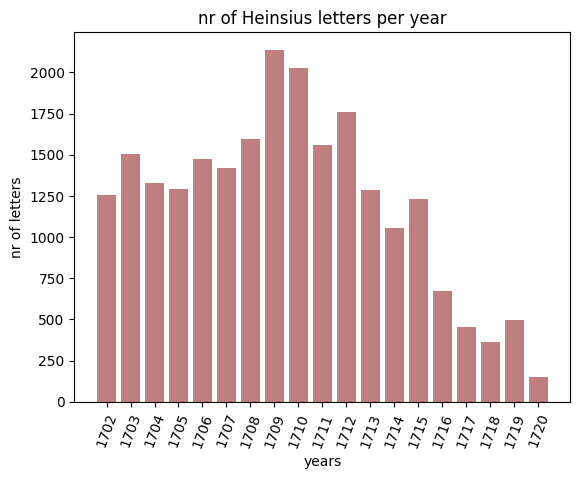

In [115]:
# now visualize
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

objects = Counter([row.get('y') for row in outrows if row.get('y')])
years = list(objects.items())
years.sort()
vales = [r[1] for r in years]
y_pos = np.arange(len(years))
plt.bar(y_pos, vales, color='maroon', align='center', alpha=0.5)
plt.xticks(rotation=70)
plt.xticks(y_pos, [r[0] for r in years])
plt.ylabel('nr of letters')
plt.xlabel('years')
plt.title('nr of Heinsius letters per year')


 
plt.show()

In [116]:
yrs = pd.to_numeric(df.loc[(df_with_actual_page_nembers.y.notna()) &
                          (df_with_actual_page_nembers.fromto=='to')].y)
yrs.transpose().plot()


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).